# 2. Using Backbone Models and Fine Tuning 

### 2.1 Create the Autoencoder and training it on Block 1 images

In [1]:
# Summary of Part 2: Data Preparation for Autoencoder Training and Transfer Learning
# --------------------------------------------------------------

# Same datasets prepared in Part 1:
# - Images are already normalized to [0,1] and resized to 128x128.
# - Regression and classification labels are prepared (float32 for regression, one-hot for classification).
# - Dataset is already split into Training, Validation, and Test sets.

# No additional preprocessing is needed at this stage because:
# 1. Autoencoder training will use on-the-fly augmentation, so pre-augmenting is unnecessary.
# 2. Classification models will handle any imbalance via class weights and dynamic augmentation.
# 
# This notebook will cover:
# - Splitting datasets into appropriate subsets (block 1 and block 2, other than Test set)
# - Autoencoder training on Block 1 images

(a) Import necessary libraries

(b) Load prepocessed, saved datasets, created in Part 1

(c) Define Blocks sizes for autoencoder and classification and create datasets

(d) Create Data Augmentation pipeline for the autoencoder

In [1]:
# (a) Import necessary libraries
# ----------------------------------------------------------------------

import numpy as np
import tensorflow as tf
from tensorflow import keras                # for implementing neural networks  //  it includes all the Keras submodules

from tensorflow.keras import Model, Input           # for building models
from tensorflow.keras.optimizers import Adam        # for optimization algorithms

import random                       # for random number generation

from sklearn.model_selection import train_test_split                    # for splitting datasets
from sklearn.utils.class_weight import compute_class_weight             # for handling class imbalance
from sklearn.metrics import classification_report, confusion_matrix     # for model evaluation

import matplotlib.pyplot as plt         # for plotting  graphs and images
import json                             # for handling JSON files
#import seaborn as sns                   # for statistical data visualization
# ----------------------------------------------------------------------

In [2]:
# (b) Load preprocessed, saved datasets, created in Part 1
# ----------------------------------------------------------------------

# training/validation/testing datasets for normalised images (Feature inputs: pixel values)
X_train_norm = np.load('X_train_norm.npy')              # scaled images between 0 and 1 
X_val_norm = np.load('X_val_norm.npy')
X_test_norm = np.load('X_test_norm.npy')
#  ----> these normalized image datasets will be used for both autoencoder and classification tasks 

# training/validation/testing datasets for regression (Target features labels: age in years)
#y_train_reg = np.load('y_train_reg.npy')                # converted from default int64 to float32
#y_val_reg = np.load('y_val_reg.npy')
#y_test_reg = np.load('y_test_reg.npy')
#  ----> those regression datasets are not needed in this notebook as we are focusing autoencoder (that is unsupervised) and classification tasks only

# training/validation/testing datasets for classification (Target features labels: age groups)
y_train_cls_ohe = np.load('y_train_cls_ohe.npy')        # transformed from integer labels to one-hot encoded format (2D arrays with binary values for each class)
y_val_cls_ohe = np.load('y_val_cls_ohe.npy')
y_test_cls_ohe = np.load('y_test_cls_ohe.npy')
#  ----> these classification datasets will be used as target labels for classification tasks
# --------------------------------------------------------------------


In [4]:
# (c) Define Blocks sizes for autoencoder and classification and create datasets
# --------------------------------------------------------------------

# Combine training and validation sets for Part 2 splitting
X_non_test = np.concatenate((X_train_norm, X_val_norm), axis=0)
#y_non_test_reg = np.concatenate((y_train_reg, y_val_reg), axis=0)
y_non_test_cls_ohe = np.concatenate((y_train_cls_ohe, y_val_cls_ohe), axis=0)

N_non_test = len(X_non_test)                            # total number of rows in non-test dataset    
print(f"Total non-test images: {N_non_test}")

# Define Block 1 and Block 2 sizes  //  Block 1: Autoencoder (larger portion)  //  Block 2: Classification (smaller portion)
BLOCK1_PCT = 0.6                            # 60% for autoencoder
block1_size = int(BLOCK1_PCT * N_non_test)
block2_size = N_non_test - block1_size

print(f"Block 1 (autoencoder) size: {block1_size}")
print(f"Block 2 (classification) size: {block2_size}")

# Shuffle and split the non-test dataset into Block 1 and Block 2
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Shuffle indices
indices = list(range(N_non_test))               # create a list of indices from 0 to N_non_test-1
random.shuffle(indices)

# Split indices into Block 1 and Block 2
block1_indices = indices[:block1_size]          # first part of shuffled indices for Block 1
block2_indices = indices[block1_size:]          # remaining part of shuffled indices for Block 2

# create Block 1 dataset for autoencoder training   
X_block1_input = X_non_test[block1_indices]             # for autoencoder, target is same as input (the reconstructed images)
y_block1_target = y_non_test_cls_ohe[block1_indices]    # although not used in autoencoder, it willl be saved and used later for fine-tuning and classification    


# create Block 2 dataset for classification training
X_block2_input = X_non_test[block2_indices]                 # input images for classification
y_block2_target = y_non_test_cls_ohe[block2_indices]        # target labels for classification (one-hot encoded), same order as X_block2_input

print(f"Block 1 images shape: {X_block1_input.shape}")
print(f"Block 2 images shape: {X_block2_input.shape}, labels shape: {y_block2_target.shape}")

# Save the created Block 1 and Block 2 datasets for later use
np.save('X_block1_input.npy', X_block1_input)
np.save('y_block1_target.npy', y_block1_target)
np.save('X_block2_input.npy', X_block2_input)
np.save('y_block2_target.npy', y_block2_target)
# --------------------------------------------------------------------

Total non-test images: 8804
Block 1 (autoencoder) size: 5282
Block 2 (classification) size: 3522
Block 1 images shape: (5282, 128, 128, 3)
Block 2 images shape: (3522, 128, 128, 3), labels shape: (3522, 6)


In [5]:
# (d) Create Data Augmentation pipeline for the autoencoder (it will be used later during training, on-the-fly)
# --------------------------------------------------------------------

# The pipeline will be used later during training, on-the-fly; so it does not modify the original datasets.  

# Data augmentation is needed to increase the diversity of training data for the autoencoder, improving its ability to generalize and learn robust features, reducing overfitting.
# Wihout augmentation, the autoencoder may memorize training images instead of learning useful representations.

# flip images horizontally, rotate, and zoom for augmentation
    # flipping helps with left-right orientation variance (e.g., head turns, poses, etc.)
    # rotation helps with slight angle variations (e.g., tilted heads, camera angles, etc.)
    # zoom helps with scale variations (e.g., distance from camera, cropping, etc.)

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),            # randomly flip images horizontally
    keras.layers.RandomRotation(0.1),                 # randomly rotate images by up to 10%
    keras.layers.RandomZoom(0.1),                     # randomly zoom in/out by up to 10%
# limited to these 3 augmentations (realistic transformations only) to avoid excessive distortion     
])

# ---> each original image is transformed into multiple augmented versions on-the-fly (during training) using tf.data pipeline (without needing to store all augmented images explicitly);
# -----> each images will be augmented differently in each epoch, providing more variability, for a total of variations per image (seen by the model) equal to the number of epochs.          
# -------> the effective dataset size is larger, but the actual dataset size is unchanged.
# --------------------------------------------------------------------


(e) Build the encoder and decoder models as a functions

(f) Build the complete autoencoder by combining encoder and decoder

(g) Extract the pretrained encoder for transfer learning

(h) Evaluate how the autoencoder performed on reconstructing images from Block 1

(i) Analysis of autoencoder performance

In [6]:
# (e) Build the encoder and decoder models as a functions
# --------------------------------------------------------------------

# (x) is addded at the end of each layer to represent the output of that layer, which is then passed as input to the next layer
# bottleneck is the latent space (compressed representation as a vector) between encoder and decoder; it is the output of the encoder and input to the decoder.

# Encoder model (to be used later in both autoencoder and classification tasks as a backbone)
def build_encoder(latent_dim=128):                                              # latent_dim: dimension of the latent space (bottleneck); it controls the compression level

    encoder_inputs = keras.Input(shape=(128, 128, 3))                           # input shape: 128x128 RGB images   

    # Apply on-the-fly data augmentation
    x = data_augmentation(encoder_inputs)                                       # augment input images

    # Convolutional layers to extract features and reduce spatial dimensions   
    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)   # first conv layer with 32 filters of size 3x3, padding to preserve spatial dimensions
    x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)                    # downsample by a factor of 2 using max pooling

    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)   # second conv layer with 64 filters of size 3x3
    x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)                    # downsample by a factor of 2

    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # third conv layer with 128 filters of size 3x3
    x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)                    # downsample by a factor of 2

    x = keras.layers.Flatten()(x)                                               # flatten the 3D feature maps to 1D feature vector
    latent = keras.layers.Dense(latent_dim, name='latent_vector')(x)            # dense layer to produce the latent representation (bottleneck)

    encoder = keras.Model(encoder_inputs, latent, name='encoder')               
    return encoder                            


# The decoder model will transform the latent representation (vector) back to the original image space, because the autoencoder's goal is to reconstruct the input images from their 
# compressed latent representations. If the image is not reconstructed back, the autoencoder fails its purpose because it cannot learn meaningful features from the data.
# Deconstruction of images from latent space is essential for training the autoencoder to minimize reconstruction loss (difference between input and output images).

# Decoder model (to be used later in autoencoder task)
def build_decoder(latent_dim=128):                                                      # latent_dim: dimension of the latent space (bottleneck); must match encoder's output

    latent_inputs = keras.Input(shape=(latent_dim,))                                    # input shape: latent vector of size latent_dim

    x = keras.layers.Dense(16 * 16 * 128, activation='relu')(latent_inputs)             # dense layer to expand latent vector for reconstruct the images to 16x16x128
    x = keras.layers.Reshape((16, 16, 128))(x)                                          # reshape to 3D feature maps 

    x = keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x) 

    decoder_outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
    return decoder


# If the encoder finds a good, compact representation of the essential patterns (like edges, textures, or overall face structure), the decoder can use that latent vector 
#   to reconstruct an image very similar to the original.
# If the encoder misses important features or encodes irrelevant details, the decoder will produce a blurry, distorted, or incorrect reconstruction.
# ----->  So the autoencoder’s ability to reconstruct images well is basically a test of how informative the latent vector is.
# --------------------------------------------------------------------

In [7]:
# (f) Build and train the complete autoencoder by combining encoder and decoder
# --------------------------------------------------------------------

# Convolutional Layers: 32 → 64 → 128 filters; it is common to increase the number of filters in deeper layers to capture more complex features.
#   early layers capture low-level features (edges, textures) --->  fewer filters
#   deeper layers capture complex features (eyes, nose, face structure) --->  more filters
#   doubling filters is standard practice for stable learning

# batch_size=32; it's the most commonly used batch size for CNNs and autoencoders;
#   it balances: memory usage (smaller batches use less GPU RAM), gradient stability (too small = noisy, too large = slow learning) and training speed.

# Define latent dimension (must match encoder/decoder)
latent_dim = 128

# Build models
encoder = build_encoder(latent_dim)             # build encoder model that outputs latent vectors
decoder = build_decoder(latent_dim)             # build decoder model that inputs latent vectors to reconstruct images

# Load pre-trained weights into encoder and save the unfrozen encoder model; the unfrozen models will be used later for transfer learning in classification task
encoder.load_weights('autoencoder_final.keras', by_name=True)
encoder.save('encoder_unfrozen.keras')

# Load pre-trained weights into decoder and save the unfrozen decoder model; the unfrozen models will be used later for transfer learning in classification task
decoder.load_weights('autoencoder_final.keras', by_name=True)
decoder.save('decoder_unfrozen.keras')

# Input for the autoencoder
    # Input() function defines the shape of input data for the model.
autoencoder_input = Input(shape=(128, 128, 3))              # input shape: 128x128 RGB images

# Connect encoder and decoder
encoded = encoder(autoencoder_input)        # encode input images to latent space
decoded = decoder(encoded)                  # decode latent representation back to image space

# Full autoencoder model
autoencoder = keras.Model(autoencoder_input, decoded, name="autoencoder")

# Compile autoencoder with mean squared error loss for reconstruction
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='mse')

# Display summary
autoencoder.summary()

# Train autoencoder on block 1 (unsupervised)
history_ae = autoencoder.fit(
    X_block1_input,
    X_block1_input,                     # reconstruction target is same as input as the autoencoder aims to reconstruct the input images (no labels needed, not supervised)
    validation_split=0.15,              # take 15% of Block 1 as validation
    epochs=50,
    batch_size=32,
    shuffle=True
)


# Save the autoencoder and training history
autoencoder.save('autoencoder_final.keras')
import json
with open('history_autoencoder.json', 'w') as f:
    json.dump(history_ae.history, f)                # save training history as JSON stats using .dump() instead of .write() because f is a file object and not a string 

# -----> for the age estimation task, training an autoencoder helps the model learn useful features from the facial images in an unsupervised manner.
# These learned features can then be transferred to the age classification model, improving its performance by providing a better starting point than random initialization.
# The autoencoder essentially acts as a pre-training step, allowing the model to capture important patterns in the data that are relevant for age estimation.
# -------------------------------------------------------------------- 

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 encoder (Functional)        (None, 128)               4287680   
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       4467779   
                                                                 
Total params: 8,755,459
Trainable params: 8,755,459
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
141/141 [==============================] - 107s 217ms/step - loss: 0.0376 - val_loss: 0.0212
Epoch 2/50
141/141 [==============================] - 27s 193ms/step - loss: 0.0201 - val_loss: 0.0168
Epoch 3/50
141/141 [==============================] - 27s 193ms/step - loss: 0.0174 - val_loss: 0.0152

In [ ]:
# (g) Extract the pretrained encoder for transfer learning
# -------------------------------------------------------

# The encoder part of the autoencoder has learned to extract meaningful features from the images.
# This pretrained encoder can be used as a backbone for the age classification model, leveraging the features it has already learned.
# By using the encoder weights, the classification model can benefit from the unsupervised learning done by the autoencoder, potentially improving classification accuracy 
# and reducing training time.

# Load trained autoencoder
autoencoder = tf.keras.models.load_model("autoencoder_final.keras")

# Extract encoder from autoencoder
encoder = autoencoder.get_layer('encoder')

# Freeze encoder weights so they are not modified during classifier training
for layer in encoder.layers:
    layer.trainable = False         # freeze weights initially as we need to preserve learned features during initial classification training

# Show encoder summary
encoder.summary()

# Save the frozen encoder for reuse
encoder.save("encoder_frozen.keras")

# Extract latent features once and save them to .npy files for later use in classification tasks

# Load frozen encoder
frozen_encoder = tf.keras.models.load_model("encoder_frozen.keras")

# Get latent features for Block 2 and Test sets
X_block2_latent = frozen_encoder.predict(X_block2_input)            # latent features for Block 2 set for later transfer learning
X_test_latent   = frozen_encoder.predict(X_test_norm)               # latent features for Test set for later evaluation

# Save latent features to .npy files for later use
np.save("X_block2_latent.npy", X_block2_latent)
np.save("X_test_latent.npy",   X_test_latent)
# --------------------------------------------------------------------



Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                       

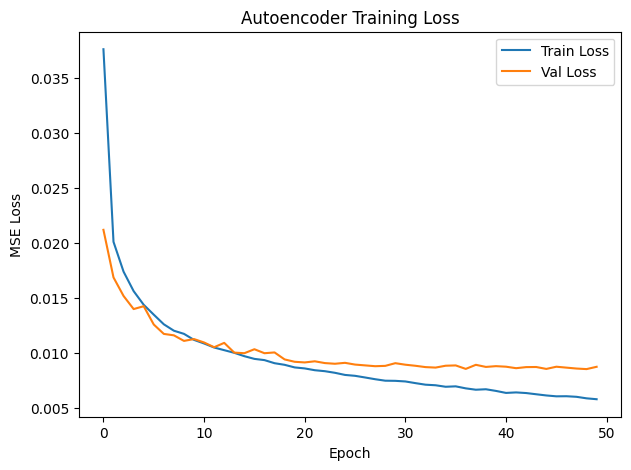

1/1 [==============================] - 0s 20ms/step


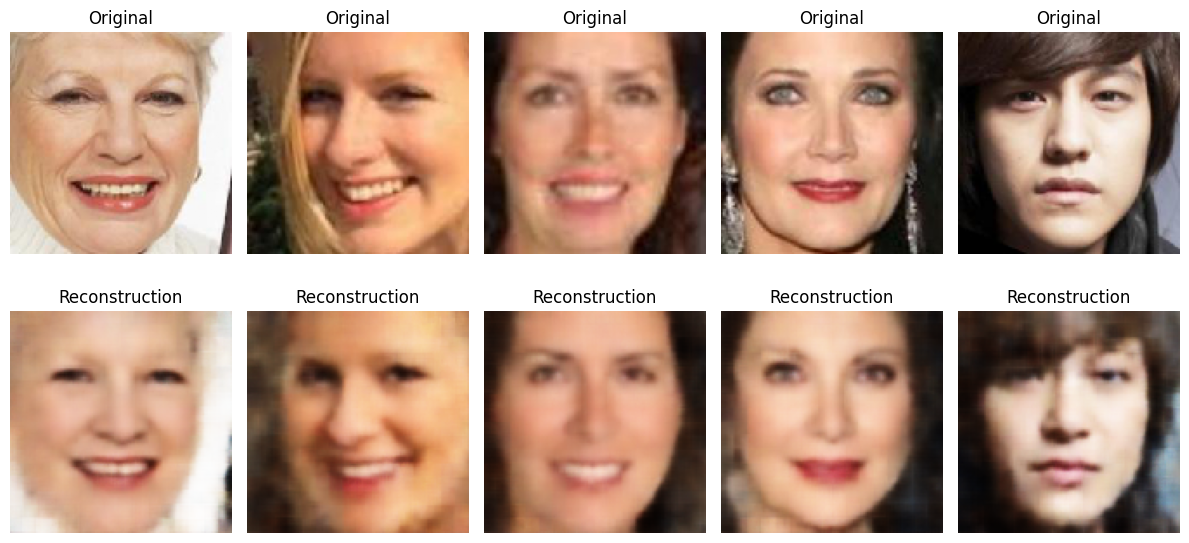

46/46 [==============================] - 2s 33ms/step


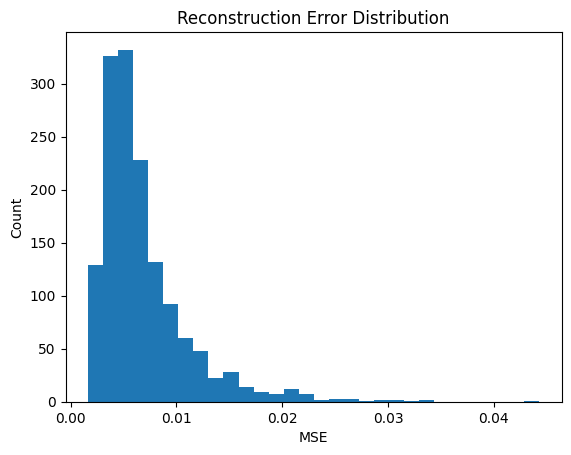

In [10]:
# (h) Evaluate how the autoencoder performed on reconstructing images from Block 1
# --------------------------------------------------------------------

# 1. Plot training and validation loss over epochs

# Load training history
with open('history_autoencoder.json', 'r') as f:
    history = json.load(f)

# Plot loss curves
plt.figure(figsize=(7,5))
plt.plot(history["loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


# 2. Visualize some original vs reconstructed images from Block 1

# Pick some random validation images
n = 5                                               # number of samples to display
idx = np.random.choice(len(X_val_norm), n)          # n random indices for samples among the total recorded images in the validation set
samples = X_val_norm[idx]                           # select the samples at the chosen n indices

# Get reconstructions
recons = autoencoder.predict(samples)               # use the autoencoder to reconstruct the selected n samples

# Plot input vs reconstruction
plt.figure(figsize=(12, 6))
for i in range(n):
    # Original
    plt.subplot(2, n, i+1)                          # 2 subplot for original images; n images in a row; i+1 is the position of the current image
    plt.imshow(samples[i])                          # display original image
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    plt.subplot(2, n, n+i+1)
    plt.imshow(recons[i])                           # display reconstructed image
    plt.title("Reconstruction")
    plt.axis("off")

plt.tight_layout()
plt.show()

# 3. Aanity check: reconstruction error distribution
recon = autoencoder.predict(X_val_norm)
mse = np.mean((X_val_norm - recon)**2, axis=(1,2,3))

plt.hist(mse, bins=30)
plt.title("Reconstruction Error Distribution")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.show()

In [ ]:
# (i) Analysis of autoencoder performance
# --------------------------------------

# The training and validation loss curves show how well the autoencoder learned to reconstruct images over time.
    # The training and validation loss both go down smoothly over time; this shows the autoencoder learned correctly without weird jumps or instability.
    # Validation loss is a bit higher than training loss, meaning there is some overfitting, but it is small and can be acceptable.

# The original vs reconstructed images allow visual assessment of reconstruction quality.
        # https://medium.com/geekculture/face-image-reconstruction-using-autoencoders-in-keras-69a35cde01b0
        # https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/
    # The autoencoder seem to  reconstruct images capturing overall facial structure, colors and pose well, but it tend to produce blurry outputs (especially in fine details like hair, 
        # sharp edges or textures).
    # The blurriness is likely due to the fact that the latent space of Autoencoders is not continuous, since they only learn one latent representation for the data;
    # considering that the entire image is compressed into a very small 128-dimensional latent vector, the results are reasonable: by compressing down to just 128 dimensions, 
        # a lot of information is lost.
    # The autoencoder’s main purpose is to learn meaningful features in the latent space that can be transferred to the age classification task (not pixel-perfect reconstruction).

# The reconstruction error distribution histogram shows how well the autoencoder performed across all validation images.
    # Most images have low reconstruction error, with only a few that are harder for the model to reconstruct.

# -----> Overall, the autoencoder appears to have learned useful features from the images and can reconstruct them reasonably well, 
    # which is promising for transfer learning to the classification task.